# Macaulays methode

Macaulays methode is een methode waarmee de verplaatsingsfunctie van een ligger van meerdere segmenten kan worden bepaald in één functie {cite}`macaulay`. Daarbij is het niet nodig om een balk onder te verdelen in segmenten met randvoorwaarden (afhankelijk van verdeelde belastingen, puntlasten, opleggingen, etc.) en blijft de notatie direct herkenbaar bij integratie/differentiatie (in tegenstelling tot de Dirac delta / Heaviside functies). Er bestaat een implementatie voor deze methode voor balken, maar een uitbreiding naar 2d-constructies zoals portalen ontbreekt.

## Voorbeeld Macaulays methode zonder uitbreidingen

Laten we de volgende constructie bekijken:

```{figure} ./figures/Example_figure.svg
:height: 300 px
:name: example_figure
Voorbeeld constructie
```

### Definieer belasting

Deze belasting (inclusief oplegreacties) kan als volgt worden beschreven volgens Macaulay:

$$q\left( x \right)=\underbrace{{{A}_{v}}{{\left\langle x \right\rangle }^{-1}}+{{B}_{v}}{{\left\langle x-15 \right\rangle }^{-1}}}_{\text{oplegreacties}}\underbrace{+10{{\left\langle x \right\rangle }^{0}}-10{{\left\langle x-4 \right\rangle }^{0}}}_{\text{verdeelde belasting}}\underbrace{+35{{\left\langle x-9 \right\rangle }^{-1}}}_{\text{puntlast}}$$

Dit kan in sympy worden genoteerd als:

In [9]:
import sympy as sym
sym.init_printing()

In [10]:
x = sym.symbols('x')
EI = sym.symbols('EI')
C_1, C_2, C_3, C_4 = sym.symbols('C_1 C_2 C_3 C_4') 
A_v, B_v = sym.symbols('A_v B_v')

Q = 10
L = 15
a = 4
b = 5
F = 35

q =  A_v * sym.SingularityFunction(x,0,-1) + Q * sym.SingularityFunction(x,0,0) - Q * sym.SingularityFunction(x,a,0) + F * sym.SingularityFunction(x, a+b, -1) + B_v * sym.SingularityFunction(x,L,-1)
display(q)

### Definieer randvoorwaarden

Voor dit probleem gelden de volgende randvoorwaarden:

$$\begin{align}
  & w\left( 0 \right)=0 \\ 
 & w\left( 15 \right)=0 \\ 
 & M\left( 0 \right)=0 \\ 
 & M\left( 15 \right)=0 \\ 
 & V\left( {{0}^{-}} \right)=0 \\ 
 & V\left( {{15}^{+}} \right)=0 \\ 
\end{align}$$

Dit kan in sympy als volgt worden gedefinieerd:

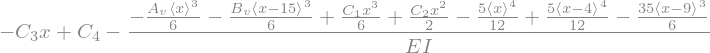

In [12]:
V = -sym.integrate(q, x) + C_1
M = sym.integrate(V, x) + C_2
kappa = M / EI
phi = sym.integrate(kappa, x) + C_3
w = -sym.integrate(phi, x) + C_4
display(w)

De dwarskracht net links van $0$ en net rechts van $15$ wordt gemodelleerd met een 'dummy'-variabele van $\cfrac{1}{\infty}$.

In [13]:
oo = sym.Dummy('oo', prime=True)
very_small = 1/oo

Nu kunnen in SymPy de vergelijkingen voor de randvoorwaarden worden opgesteld:

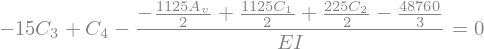

In [16]:
Eq1 = sym.Eq(w.subs(x,0),0)
Eq2 = sym.Eq(w.subs(x,L),0)
Eq3 = sym.Eq(M.subs(x,0),0)
Eq4 = sym.Eq(M.subs(x,L),0)
Eq5 = sym.Eq(V.subs(x,0-very_small),0).subs(oo,sym.oo)
Eq6 = sym.Eq(V.subs(x,L+very_small),0).subs(oo,sym.oo)
display(Eq1, Eq2, Eq3, Eq4, Eq5, Eq6)

### Los op voor randvoorwaarden
Oplossen naar de randvoorwaarden geeft:

$$w\left( x \right)=\frac{26692x\underbrace{-292{{\left\langle x \right\rangle }^{3}}-158{{\left\langle x-15 \right\rangle }^{3}}}_{\text{oplegreacties}}\underbrace{+15{{\left\langle x \right\rangle }^{4}}-15{{\left\langle x-4 \right\rangle }^{4}}}_{\text{verdeelde belasting}}\underbrace{+210{{\left\langle x-9 \right\rangle }^{3}}}_{\text{puntlast}}}{36EI}$$

welke oplossing ook met code kan worden gevonden:

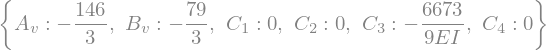

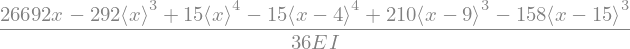

In [17]:
sol = sym.solve((Eq1,Eq2,Eq3,Eq4,Eq5,Eq6),(C_1,C_2,C_3,C_4,A_v,B_v))
display(sol)

display(w.subs(sol).factor(EI))

Dit kan ook worden omgeschreven naar een functie per domein:

$\displaystyle \begin{cases} \frac{79 x^{3} - 3555 x^{2} + 40781 x - 78465}{18 EI} & \text{for}\: x > 9 \\\frac{- 13 x^{3} - 360 x^{2} + 7633 x - 960}{9 EI} & \text{for}\: x > 4 \\\frac{x \left(15 x^{3} - 292 x^{2} + 26692\right)}{36 EI} & \text{for}\: x > 0\end{cases}$

wat met de volgende code kan worden gevonden:

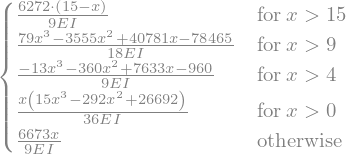

In [18]:
display(sym.simplify(w.subs(sol).rewrite(sym.Piecewise)))

Dit resultaat kan ook worden geplot voor een $EI$ van $10000$:

In [19]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']

In [20]:
w_numpy = sym.lambdify(x, w.subs(sol).subs(EI,10000).rewrite(sym.Piecewise))

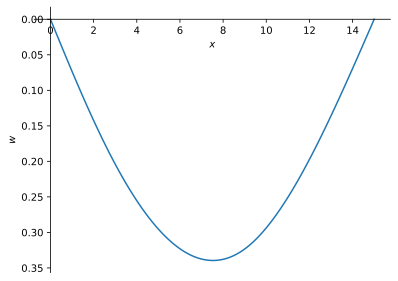

In [21]:
x_numpy = np.linspace(0,15,100)
plt.figure()
plt.plot(x_numpy,w_numpy(x_numpy))
plt.xlabel('$x$')
plt.ylabel('$w$');
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.invert_yaxis()

The dwarskrachtverdeling kan ook worden gevonden:

$$V\left( x \right)=\underbrace{\frac{146{{\left\langle x \right\rangle }^{0}}}{3}+\frac{79{{\left\langle x-15 \right\rangle }^{0}}}{3}}_{\text{oplegreacties}}\underbrace{-10{{\left\langle x \right\rangle }^{1}}+10{{\left\langle x-4 \right\rangle }^{1}}}_{\text{verdeelde belasting}}\underbrace{-35{{\left\langle x-9 \right\rangle }^{0}}}_{\text{puntlast}}$$

met de volgende code:

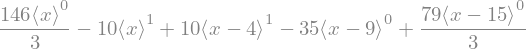

In [22]:
display(V.subs(sol))

En ook deze formule kan worden omgeschreven naar een formule per domein:

$$\displaystyle \begin{cases} - \frac{79}{3} & \text{for}\: x > 9 \\\frac{26}{3} & \text{for}\: x > 4 \\\frac{146}{3} - 10 x & \text{for}\: x > 0 \end{cases}$$

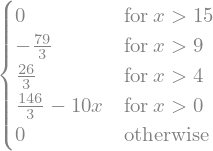

In [23]:
display(sym.simplify(V.subs(sol).rewrite(sym.Piecewise)))

en kan ook worden geplot:

In [12]:
V_numpy = sym.lambdify(x, V.subs(sol).rewrite(sym.Piecewise))

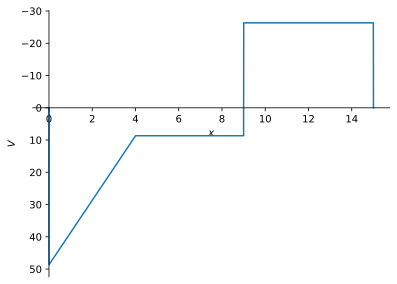

In [13]:
x_numpy = np.linspace(0,15.01,10000)
plt.figure()
plt.plot(x_numpy,V_numpy(x_numpy))
plt.xlabel('$x$')
plt.ylabel('$V$');
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.invert_yaxis()

## Voorbeeld Macaulays methode in SymPy


De methode van Macaulay is ook geïmplementeerd in SymPy en kan daar worden toegepast zonder vergelijkingen op te moeten stellen.

Let op: het assenstelsel is in SymPy gedefinieerd met de verticale as positief naar boven.

In [1]:
import sympy as sym
from sympy.physics.continuum_mechanics.beam import Beam
sym.init_printing()

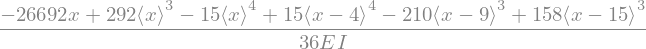

In [6]:
E, I = sym.symbols('E, I')
b = Beam(15, E, I)
A_v = b.apply_support(0,type='pin')
B_v = b.apply_support(15,type='roller')
b.apply_load(-10, 0, 0, 4)
b.apply_load(-35, 9, -1)
b.solve_for_reaction_loads(A_v, B_v)
b.deflection().simplify()

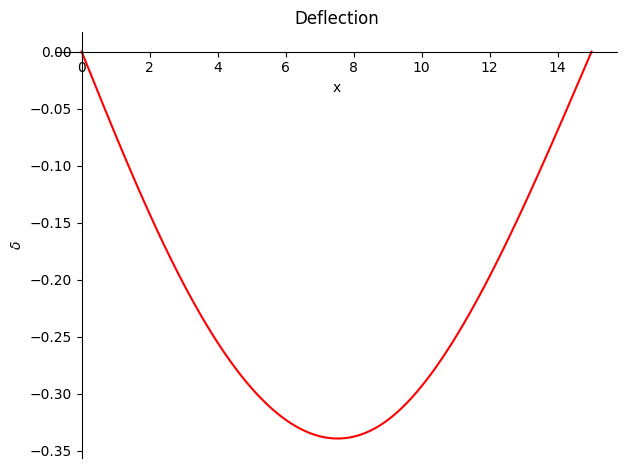

In [9]:
b.plot_deflection({E : 10000, I : 1});

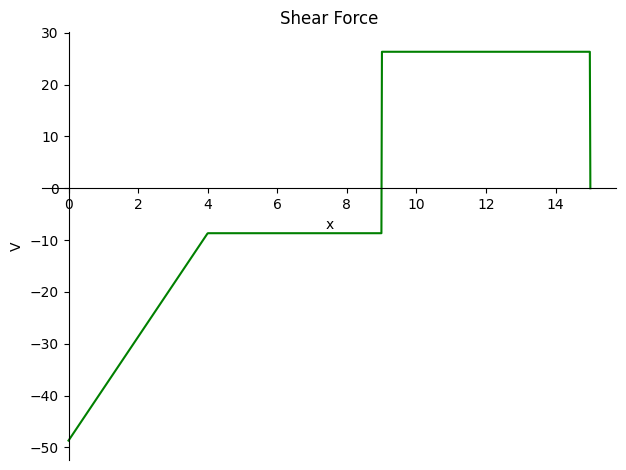

In [11]:
b.plot_shear_force();